<h3 style='text-align: right;'> Geophysics Independent Project </h3>

## Notebook 5: Computing seismogram amplitude

At this point, you know most of the steps in the core of observational seismology.  You can identify available seismic stations, download seismic data, remove the instrument response, filter the data to periods you're interested in, and plot the ground shaking.

Often, however, we're not interested in the details of ground shaking.  We just want to know how big the shaking is.  So in this notebook, you'll learn to (1) estimate seismic amplitude as a function of time and (2) downsample the amplitude time series so it's easier to manage.

In [1]:
import numpy as np 
import obspy
import matplotlib.pyplot as plt

### 1. Download and process some seismic data

First, of course, we need to pick some ground shaking to analyse.  Let's forget about earthquakes this time and look at anthropogenic seismic signals.  

Pick a city and find a seismic station in an urban or suburban setting and choose a few-hour or day-long period you'd like to analyse.  Choose at least two channels to consider.  (Gmap is probably the easiest way to do this: https://ds.iris.edu/gmap/.)

Do keep in mind that sometimes stations are listed, but their data aren't publicly available.   If the station you want doesn't have data, you'll have to pick somewhere else.

_Q1. Which station, channels, and day did you pick?_


Your answer here.

In [2]:
# I've picked a station near Swindon run by the BGS
station='SWN1'
network='GB'

# and I'll pick the 100-Hz rather than the 50-Hz data, as I might be interested in high-frequency signals
channels='HH?'

# let's choose an arbitrary Monday morning in November
t1 = obspy.UTCDateTime(2023,11,13,9,0,0)

# two hours from 09:00 UTC
# NB: if everything is running very slowly, just try a shorter interval
t2 = t1 + 2*3600

# but add a bit at the beginning and the end to accommodate filtering and trimming
t1_grab=t1-300
t2_grab=t2+300

In [3]:
# open a connection to the data centre

# this line creates a shortcut to the function obspy.clients.fdsn.client.Client
from obspy.clients.fdsn.client import Client

# and this line calls the function Client to establish a connection to IRIS.
# gmap tells me the data is archived at IRIS
client = Client("IRIS")

In [4]:
# download the data
st = client.get_waveforms(network=network,station=station,location="*",channel=channels, 
                            starttime=t1_grab,endtime=t2_grab,attach_response=True)

3 Trace(s) in Stream:
GB.SWN1..HHE | 2023-11-13T08:55:00.000000Z - 2023-11-13T11:05:00.000000Z | 100.0 Hz, 780001 samples
GB.SWN1..HHN | 2023-11-13T08:55:00.000000Z - 2023-11-13T11:05:00.000000Z | 100.0 Hz, 780001 samples
GB.SWN1..HHZ | 2023-11-13T08:55:00.000000Z - 2023-11-13T11:05:00.000000Z | 100.0 Hz, 780001 samples


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


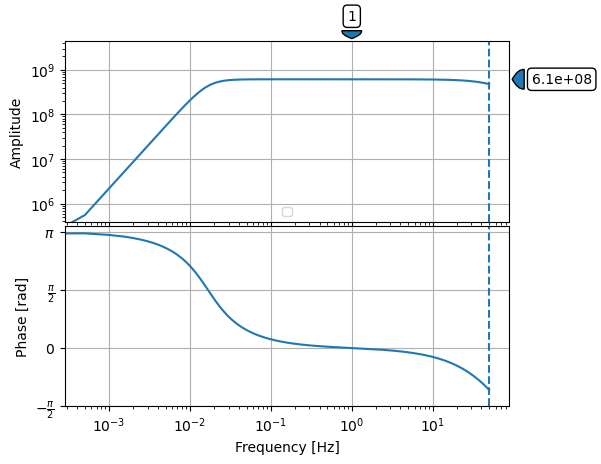

In [5]:
# and see what we've got
print(st)

# maybe also check response at various frequencies
st[0].stats.response.plot(min_freq=0.0005);

In [6]:
# correct for response, with a pre-filter
# this pre-filter says we'll ignore periods longer than 200 s
st.remove_response(output='VEL',pre_filt=[0.001,0.005,float('inf'),float('inf')]);

# note that if you have a long interval, this step might take a minute

In [9]:
# let's check the units so we can have a label
st[0].stats.response

Channel Response
	From m/s (VELOCITY IN METERS PER SECOND) to counts (DIGITAL COUNTS)
	Overall Sensitivity: 6.12572e+08 defined at 1.000 Hz
	2 stages:
		Stage 1: PolesZerosResponseStage from m/s to V, gain: 1966.52
		Stage 2: CoefficientsTypeResponseStage from V to counts, gain: 311500

_Q2: Modify the code below to plot a half-hour portion of your data.   Why do I suggest plotting half an hour rather than the entire day of data?_

Your answer here.

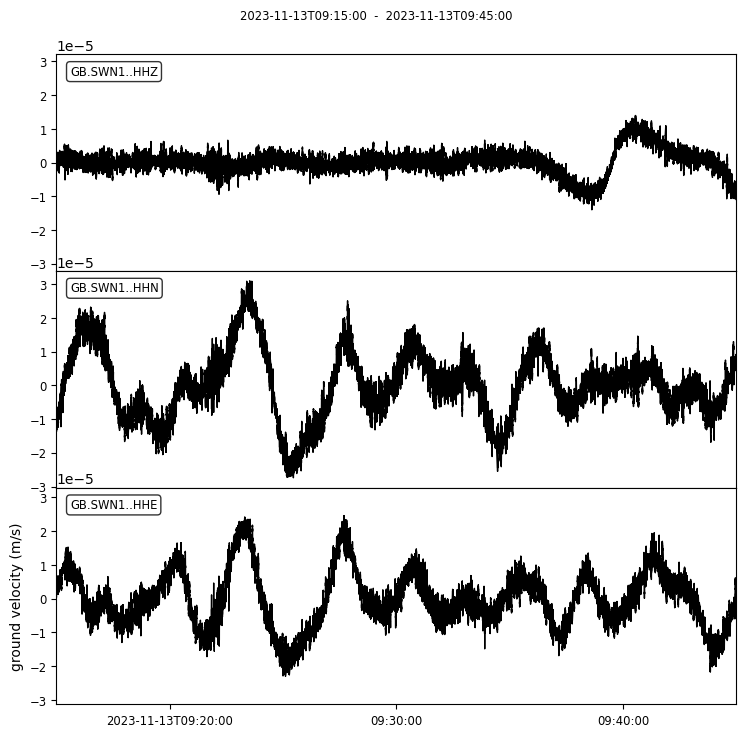

In [10]:
# let's plot a half-hour-long portion of the data
tstart = obspy.UTCDateTime(2023,11,13,9,15,0)
h=st.plot(starttime=tstart,endtime=tstart+1800,handle=True);
h.gca().set_ylabel('ground velocity (m/s)');

_Q3: What do you see?  Any interesting or interpretable in the seismogram?_

Your answer here

### 2. Filter to focus on a particular frequency band

It's likely, however, that we're not interested ground motion at all timescales.  Let's focus on just one frequency band for now: say 1-10 Hz.

In [8]:
# make a copy of the seismic data you've downloaded
# this way you can go back and filter it to other frequencies later
stf=st.copy()

# detrend and taper the edges: good filtering practice
stf.detrend()
stf.taper(max_length=100,max_percentage=0.1)

# and filter
stf.filter('bandpass',freqmin=1,freqmax=10)

3 Trace(s) in Stream:
GB.SWN1..HHE | 2023-11-13T08:55:00.000000Z - 2023-11-13T11:05:00.000000Z | 100.0 Hz, 780001 samples
GB.SWN1..HHN | 2023-11-13T08:55:00.000000Z - 2023-11-13T11:05:00.000000Z | 100.0 Hz, 780001 samples
GB.SWN1..HHZ | 2023-11-13T08:55:00.000000Z - 2023-11-13T11:05:00.000000Z | 100.0 Hz, 780001 samples

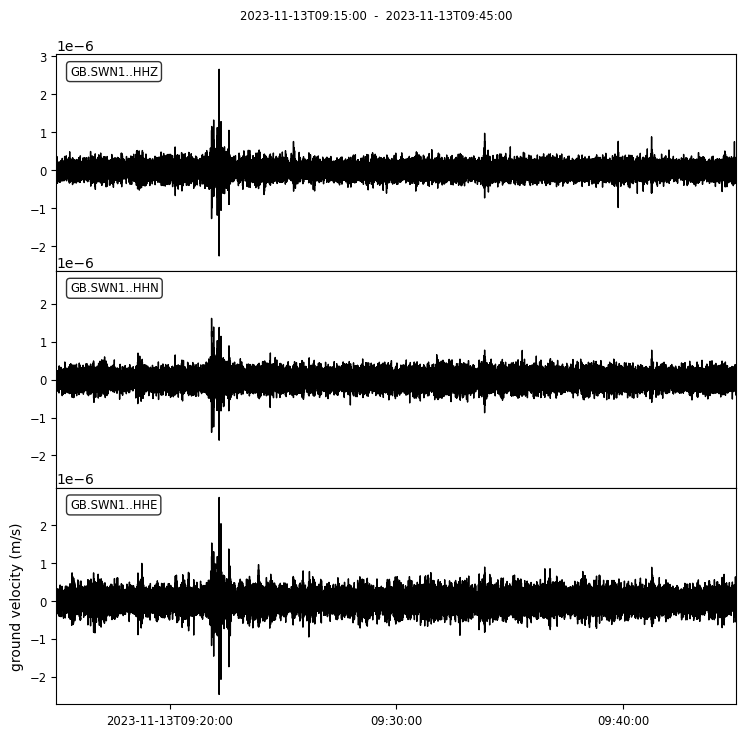

In [12]:
# plot again
# hopefully we've removed some of the long-period noise
h=stf.plot(starttime=tstart,endtime=tstart+1800,handle=True);
h.gca().set_ylabel('ground velocity (m/s)');

### 2. How to compute the amplitude of a time series

The seismic observation you've picked may or may not have anything that's obviously interesting in it.  But perhaps there are interesting trends.  For instance, say we want to know whether ground shaking is usually biggest in the morning, afternoon, or evening.  We'd like to have a quick estimate of seismic amplitude.

To do so, we'll estimate the "envelope" of the seismogram.  

In case you're interested, the envelope uses a Hilbert transform approach (https://en.wikipedia.org/wiki/Hilbert_transform).  The Hilbert transform (effectively) considers a signal to be made up of sines and cosines.  Then it shifts all of the sines and cosines a quarter-period to the right.  Now all the sines are cosines, and all the cosines are sines.  And that turns out to be a perfect tool to start doing an amplitude amplitude calculation.  Say we had a sinusoidal signal with amplitude $A$:
$$d(t) = A \cos(t).$$
The Hilbert transform of this signal would be
$$H[d(t)] = A \sin(t)$$

We can now consider _any_ time $t$ and take a few steps: (a) square the original signal and the Hilbert transformed signal, (b) add the squares together, and (c) take the square root.

$$\textrm{amplitude}(t) = \sqrt{d(t)^2 + H[d(t)]^2} = \sqrt{A^2 \cos^2(t) + A^2 \sin^2(t)} = A$$

We recover the desired amplitude $A$ no matter which time we pick, even if the original signal $d(t)$ happens to be zero at that time.

Gal Vishne has made a nice illustration of this envelope approach on Twitter.

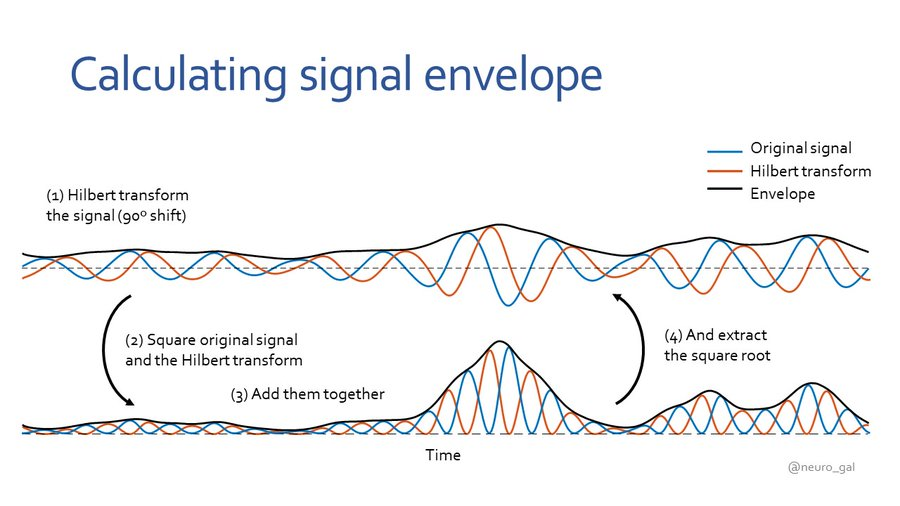



### 3. Extracting data from the seismogram traces
We'd like to compute envelopes of seismogram.  Obspy has an "envelope" function that does the above.
See also: https://docs.obspy.org/tutorial/code_snippets/seismogram_envelopes.html.

However, this function acts on a simple time series.  It's not a built-in function of the stream or trace objects.

So first, we have to grab out a portion of the ground motion time series.

In [44]:
# let's grab the second thousand points in the first (filtered) seismogram
data = stf[0].data[1000:2000]
print('Here are the data',data)

# we can also grab the *times* of these ground velocities
# relative to the trace starttime
times = stf[0].times()[1000:2000]


Here are the data [ 1.85660091e-10  1.82912090e-10  1.32622692e-10  4.34154928e-11
 -4.70681597e-11 -1.00810476e-10 -1.09313867e-10 -9.16361771e-11
 -7.06854723e-11 -5.13988537e-11 -2.50585018e-11  8.28192347e-12
  3.12962891e-11  2.01899121e-11 -3.63868693e-11 -1.21601896e-10
 -1.95427610e-10 -2.22873519e-10 -1.98351767e-10 -1.39957301e-10
 -6.65291950e-11  9.95147871e-12  7.77905687e-11  1.27445638e-10
  1.54965265e-10  1.57035186e-10  1.34887391e-10  9.94696171e-11
  5.58937206e-11 -5.17983728e-12 -8.42980154e-11 -1.54494619e-10
 -1.79339574e-10 -1.45136410e-10 -7.33212518e-11 -6.67451963e-12
  1.77247451e-11 -1.20848433e-11 -8.52340631e-11 -1.80925584e-10
 -2.76225579e-10 -3.49318503e-10 -3.81771823e-10 -3.65663691e-10
 -3.12592034e-10 -2.47801747e-10 -1.96091058e-10 -1.74150826e-10
 -1.82016866e-10 -1.99276878e-10 -1.99958492e-10 -1.73602098e-10
 -1.34041938e-10 -1.08090517e-10 -1.07563506e-10 -1.15429750e-10
 -1.12478058e-10 -1.07971493e-10 -1.23508438e-10 -1.57610357e-10
 -1.846

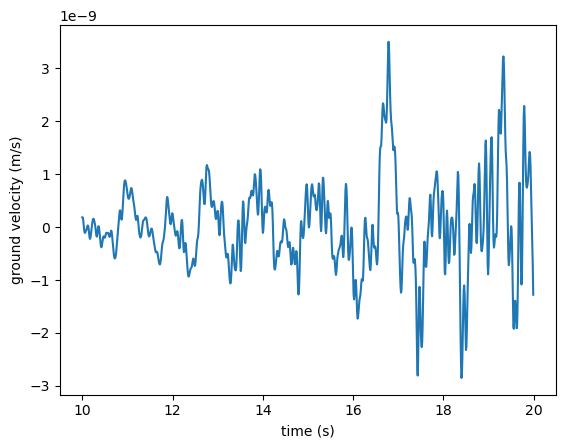

In [45]:
# and plot the data directly
plt.plot(times,data);
plt.xlabel('time (s)');
plt.ylabel('ground velocity (m/s)');

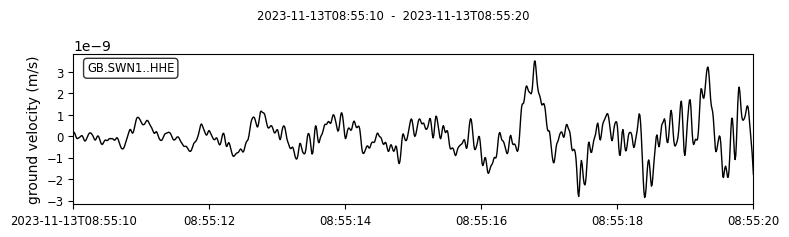

In [46]:
# let's also plot the first 10 seconds of the seismogram using the trace's built-in plotting function
tr=stf[0]
h=tr.plot(starttime=tr.stats.starttime+10,endtime=tr.stats.starttime+20,handle=True);
h.gca().set_ylabel('ground velocity (m/s)');

The plots look the same, which is good.  

_Q4: Copy and modify the code above to plot the next 10 seconds of the data---starting 20 seconds after the trace start time and finishing 30 seconds after the trace start time._

In [31]:
# your code here

### 4. Compute amplitude of a time series

Now we can go ahead and compute the envelope of the data in variable "data" and plot that.

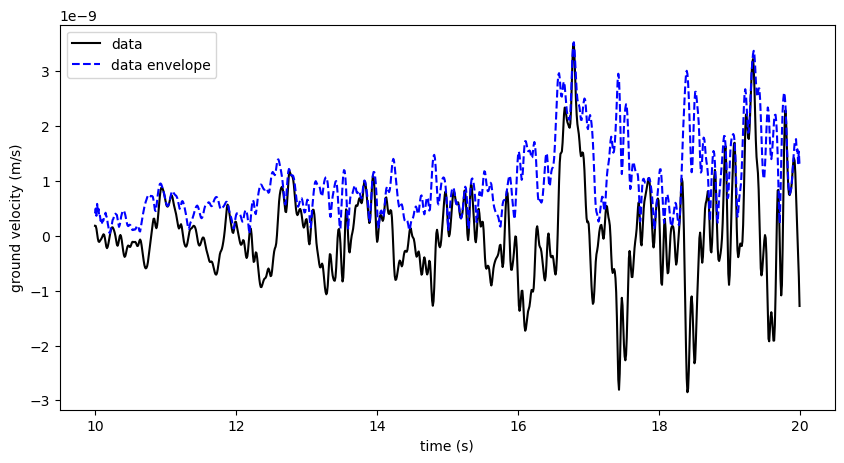

In [47]:
# make a new figure because a different aspect ratio looks better
f=plt.figure(figsize=(10,5));

# compute the data envelope
data_envelope = obspy.signal.filter.envelope(data)

# and plot the data directly
plt.plot(times,data,color='black',label='data');
plt.plot(times,data_envelope,color='blue',linestyle='--',label='data envelope');
plt.xlabel('time (s)');
plt.ylabel('ground velocity (m/s)');
plt.legend();

_Q5: The variable "data_envelope" avove contains the seismic amplitude in the window you're examining.  What is the average amplitude in this window?  Does that average match what you expect from your plot?_

Your answer here.

### 5. Creating traces with seismic amplitude

Now that we can compute seismic amplitude of a time series, we can create a set of obspy streams to contain those amplitudes.  Then we can analyse the computed amplitude with all of obspy's built-in functions.

In [69]:
# let's filter first, as the results will be more intuitive
stf=st.copy()
stf.filter('bandpass',freqmin=0.5,freqmax=2)

3 Trace(s) in Stream:
GB.SWN1..HHE | 2023-11-13T08:55:00.000000Z - 2023-11-13T11:05:00.000000Z | 100.0 Hz, 780001 samples
GB.SWN1..HHN | 2023-11-13T08:55:00.000000Z - 2023-11-13T11:05:00.000000Z | 100.0 Hz, 780001 samples
GB.SWN1..HHZ | 2023-11-13T08:55:00.000000Z - 2023-11-13T11:05:00.000000Z | 100.0 Hz, 780001 samples

In [70]:
# first let's initialize a stream to contain all our amplitude traces
st_amp=obspy.Stream()

_Q6: How many traces are in this stream when you initialize it?_

Your answer here.

In [71]:
# now we can loop through the traces with the ground velocity data
for tr in stf:
    # check the trace we're analysing
    print('Analysing this trace: ')
    print(tr)
    
    # make a copy of the trace so it has all the same metadata
    tr_amp=tr.copy()
    
    # but replace the actual data time series with the envelope
    tr_amp.data=obspy.signal.filter.envelope(tr.data)
    
    # and let's use the "location" metadata to note that we've computed an amplitude
    tr_amp.stats.location='A'
    
    print('Here is the new amplitude trace:')
    print(tr_amp)
    print('\n')
    
    # add the new trace to our stream of amplitude waveforms
    st_amp.append(tr_amp)

Analysing this trace: 
GB.SWN1..HHE | 2023-11-13T08:55:00.000000Z - 2023-11-13T11:05:00.000000Z | 100.0 Hz, 780001 samples
Here is the new amplitude trace:
GB.SWN1.A.HHE | 2023-11-13T08:55:00.000000Z - 2023-11-13T11:05:00.000000Z | 100.0 Hz, 780001 samples


Analysing this trace: 
GB.SWN1..HHN | 2023-11-13T08:55:00.000000Z - 2023-11-13T11:05:00.000000Z | 100.0 Hz, 780001 samples
Here is the new amplitude trace:
GB.SWN1.A.HHN | 2023-11-13T08:55:00.000000Z - 2023-11-13T11:05:00.000000Z | 100.0 Hz, 780001 samples


Analysing this trace: 
GB.SWN1..HHZ | 2023-11-13T08:55:00.000000Z - 2023-11-13T11:05:00.000000Z | 100.0 Hz, 780001 samples
Here is the new amplitude trace:
GB.SWN1.A.HHZ | 2023-11-13T08:55:00.000000Z - 2023-11-13T11:05:00.000000Z | 100.0 Hz, 780001 samples




In [72]:
# check that the minimum value in the amplitude data is positive
np.min(st_amp[0].data)

7.823770175132853e-10

In [73]:
# our new stream should now have several traces
print(st_amp)

3 Trace(s) in Stream:
GB.SWN1.A.HHE | 2023-11-13T08:55:00.000000Z - 2023-11-13T11:05:00.000000Z | 100.0 Hz, 780001 samples
GB.SWN1.A.HHN | 2023-11-13T08:55:00.000000Z - 2023-11-13T11:05:00.000000Z | 100.0 Hz, 780001 samples
GB.SWN1.A.HHZ | 2023-11-13T08:55:00.000000Z - 2023-11-13T11:05:00.000000Z | 100.0 Hz, 780001 samples


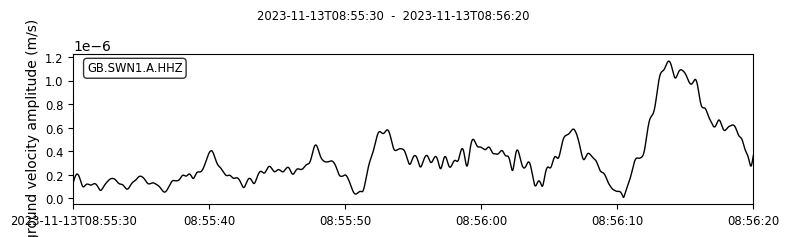

In [76]:
# let's plot a 50-second portion of the data on HHZ
tstart=st_amp[0].stats.starttime+30
tstop=tstart+50

h=st_amp.select(channel='HHZ').plot(starttime=tstart,endtime=tstop,handle=True);
h.gca().set_ylabel('ground velocity amplitude (m/s)');

_Q7: Plot the ground motion in the same time interval as that seen above.  Do they match?_

In [77]:
# your code here

### 6. Lowpass filter the amplitude time series

The envelopes above are computed for each point in the observed ground motion.  That's lots of point.  If we have 100-Hz seismic data, we have an estimate of amplitude at every 0.01 seconds.   Probably we're not interested in how seismic amplitude changes on timescales of 0.01 s.    Maybe we don't even need all the detail in the 50-s interval above.  If we were interested in wind noise, we may be happy with one value for the entire 50-second interval.

Say we're interested in how seismic amplitude changes on timescales of a minute or longer.  We can lowpass filter the amplitude time series to average out the short-period variations.

In [78]:
# copy first
st_amp_f = st_amp.copy();

# lowpass filter
st_amp_f.filter('lowpass',freq=1/60.)

3 Trace(s) in Stream:
GB.SWN1.A.HHE | 2023-11-13T08:55:00.000000Z - 2023-11-13T11:05:00.000000Z | 100.0 Hz, 780001 samples
GB.SWN1.A.HHN | 2023-11-13T08:55:00.000000Z - 2023-11-13T11:05:00.000000Z | 100.0 Hz, 780001 samples
GB.SWN1.A.HHZ | 2023-11-13T08:55:00.000000Z - 2023-11-13T11:05:00.000000Z | 100.0 Hz, 780001 samples

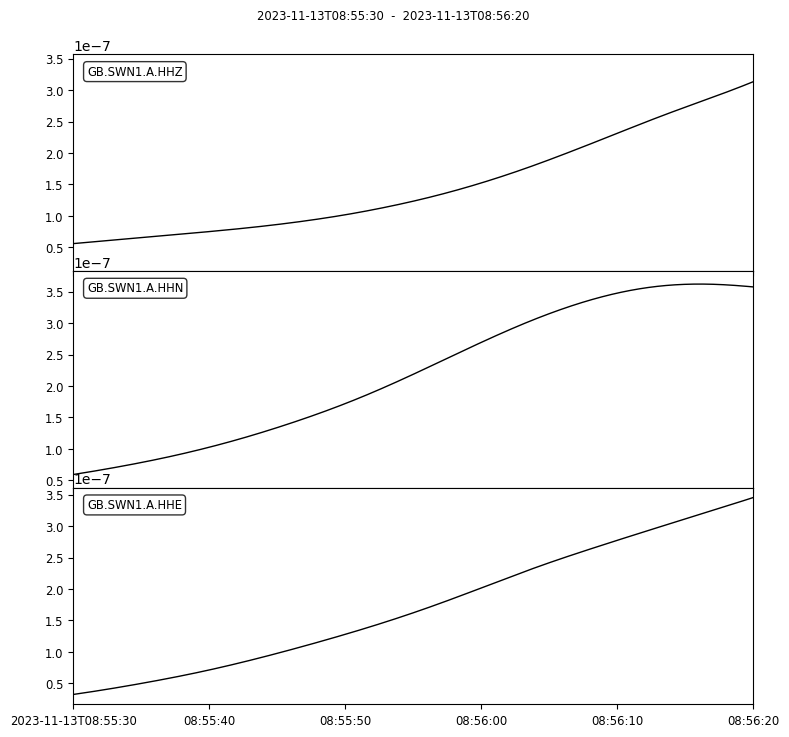

In [79]:
# and replot
st_amp_f.plot(starttime=tstart,endtime=tstop);

_Q8: Say you were instead interested variations in amplitude on timescales of 30 s.  Modify the code above to examine those variations.  Change the time limits so that you can see which periods are retained._

_Q9: Why make a copy of the trace before filtering it?_

Your answer here.

### 7. Downsample the data

We now have a nice smooth curve.  However, we have lots of samples of this curve: still every 0.01 s, perhaps.  

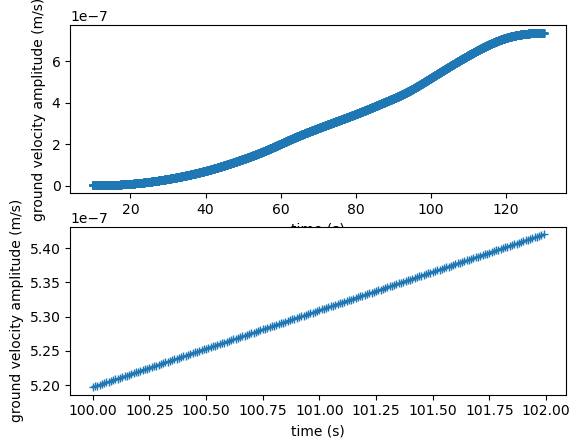

In [81]:
# let's plot an x at every point a 120-s portion of the signal
plt.subplot(2,1,1);
plt.plot(st_amp_f[0].times()[1000:13000],st_amp_f[0].data[1000:13000],marker='+');
plt.xlabel('time (s)');
plt.ylabel('ground velocity amplitude (m/s)');

# and zoom in
plt.subplot(2,1,2);
plt.plot(st_amp_f[0].times()[10000:10200],st_amp_f[0].data[10000:10200],marker='+');
plt.xlabel('time (s)');
plt.ylabel('ground velocity amplitude (m/s)');


In [82]:
# we can check the time sampling
print('Time between samples in the first trace: ',st_amp_f[0].stats.delta)
print('\n')

# and note how many values of amplitude have been recorded
print('How many samples in the first trace: ',st_amp_f[0].stats.npts)

# that's a lot

Time between samples in the first trace:  0.01


How many samples in the first trace:  780001


We don't need that many samples of the curve.  How about one sample every 10 s?  That seems enough if the amplitude is changing on timescales of 60s or longer?

In [83]:
# we'll use a simple resampling approach: just take every Nth value

# currently there's one sample every tr.stats.delta seconds
# we want a sample every 10 s
# so we want every Nth sample, where N is
N=10/st_amp_f[0].stats.delta

print('want every {:0.2f}th sample'.format(N))

# but we'd better round and convert to an integer
N=int(np.round(N))

print('want every {:d}th sample'.format(N))

# pick each value
st_amp_f.decimate(factor=N,no_filter=True)

want every 1000.00th sample
want every 1000th sample


3 Trace(s) in Stream:
GB.SWN1.A.HHE | 2023-11-13T08:55:00.000000Z - 2023-11-13T11:05:00.000000Z | 0.1 Hz, 781 samples
GB.SWN1.A.HHN | 2023-11-13T08:55:00.000000Z - 2023-11-13T11:05:00.000000Z | 0.1 Hz, 781 samples
GB.SWN1.A.HHZ | 2023-11-13T08:55:00.000000Z - 2023-11-13T11:05:00.000000Z | 0.1 Hz, 781 samples

_Q10: How often is amplitude recorded now?  How many samples are in each trace?_

Your answer here

By filtering and downsampling, you'll obtain amplitude time series with far fewer data.  That will mean less calculation and lower storage requirements.  So you'll be able to easily plot and analyse the data over days, months, or even years if you want to.

Indeed, let's go ahead and plot the amplitude for the entirety of the hours or day you've downloaded.

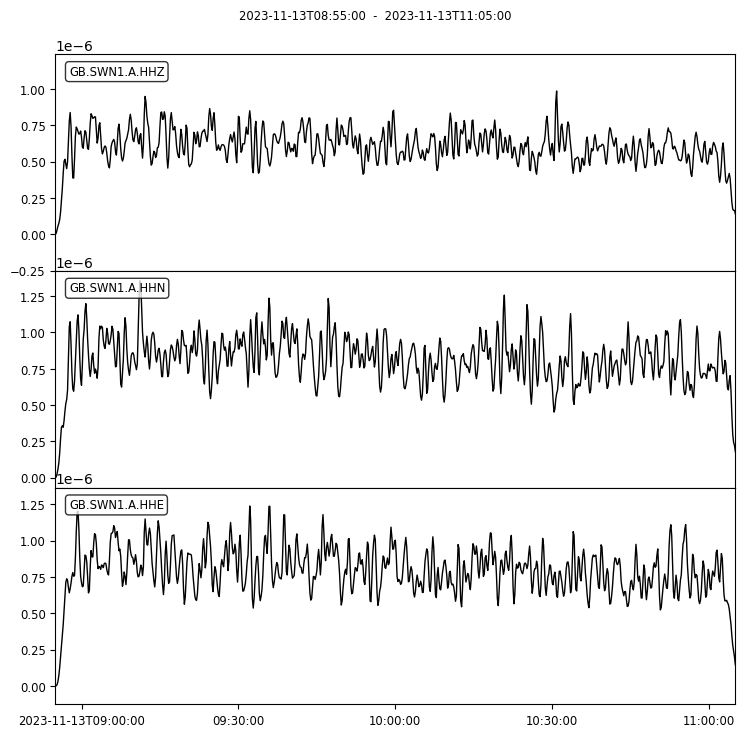

In [84]:
st_amp_f.plot();

### 8. Trim the ends

You may now notice that there's some funny stuff happening at the beginning and the end.  These are edge effects that arise in the filtering and the envelope calculation.

Fortunately, we remembered to buffer the seismograms before we downloaded and analysed them.  So let's just grab out the middle portion.


In [85]:
st_amp_f.trim(starttime=t1,endtime=t2)

3 Trace(s) in Stream:
GB.SWN1.A.HHE | 2023-11-13T09:00:00.000000Z - 2023-11-13T11:00:00.000000Z | 0.1 Hz, 721 samples
GB.SWN1.A.HHN | 2023-11-13T09:00:00.000000Z - 2023-11-13T11:00:00.000000Z | 0.1 Hz, 721 samples
GB.SWN1.A.HHZ | 2023-11-13T09:00:00.000000Z - 2023-11-13T11:00:00.000000Z | 0.1 Hz, 721 samples

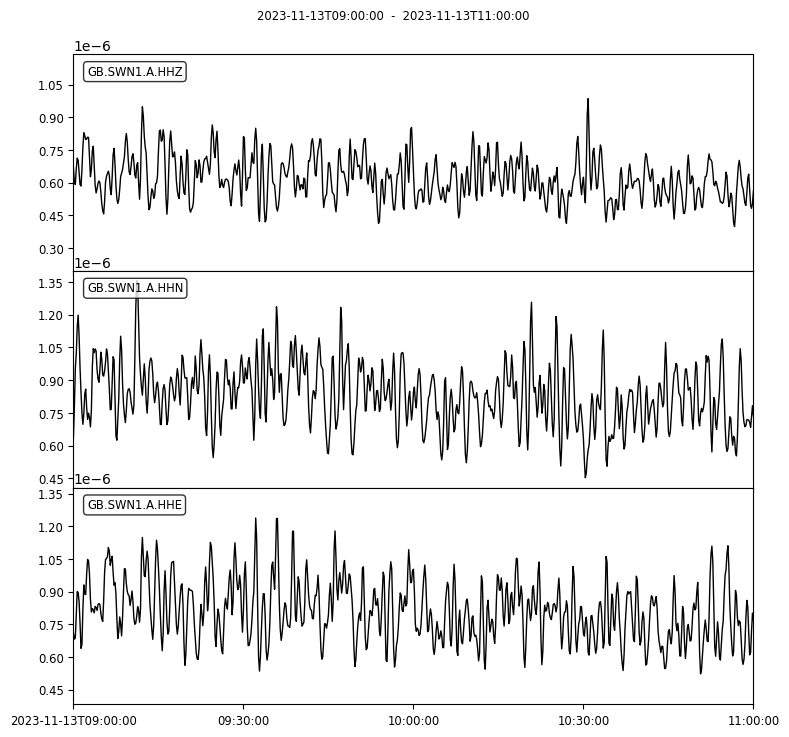

In [86]:
st_amp_f.plot();

### 9. Consider the whole time interval

_Q11. What do you notice about the amplitude over the course of the hours or day?  Speculate about what causes the ground shaking.  You may need to download more data and reprocess it._

_Note that the seismogram times are given in UTC; you may have to take time zone into account._

Your answer here.